# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1,"author":1})


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)
model_artm.initialize("dictionary", seed=1)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_author", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=1e5, dictionary_name="dictionary",class_ids=["text"],topic_names="bcg"))


Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30, num_document_passes=1)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi3', tau=-1e5, dictionary_name="dictionary",class_ids=["text"],topic_names=topic_names[: len(topic_names) - 1]))


Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15, num_document_passes=1)


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words_text"].last_topic_info[topic_name].tokens:
        print word,
    print

sbj0:  частица взаимодействие физика кварк стандартный симметрия дмитрий элементарный нейтрино материя протон масса слабый фундаментальный построить
sbj1:  материал структура температура свойство вещество химический соединение поверхность давление химия применение электронный углерод металл сверхпроводимость
sbj2:  политический государство политика власть царь партия положение труд правитель кризис враг ритуал средневековый сага борьба
sbj3:  университет объяснять школа объект предмет образование естественный познание логика восприятие студент факультет воспринимать учитель аргумент
sbj4:  слово мозг ребенок категория мышление лицо нейрон предложение конструкция значение корпус позиция контекст взрослый чтение
sbj5:  бог миф греческий герой существо след древний мифология роман грек странный сущность предок персонаж мифологический
sbj6:  русский текст город написать городской перевод сохраняться москва локальный гласный документ немецкий говор письмо пьеса
sbj7:  трудность раса праздни

In [13]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    for word in model_artm.score_tracker["top_words_author"].last_topic_info[topic_name].tokens:
        print word,
    print

sbj0:  Дмитрий_Казаков Михаил_Данилов Валерий_Рубаков Виктор_Брагута Сергей_Майоров Павел_Пахлов Игорь_Волобуев Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Сергей_Троицкий Дэвид_Гросс Сергей_Гашков Жан-Арыс_Джилкибаев
sbj1:  Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Евгений_Гудилин Дмитрий_Гольберг Валентин_Крапошин Иван_Сорокин Наталья_Берлофф Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Владимир_Комлев
sbj2:  Кирилл_Мартынов Алексей_Юдин Александр_Филиппов Михаил_Бойцов Дина_Гусейнова Иван_Ладынин Андрей_Лукашов Татьяна_Смоктунович Рафаэль_Арутюнян Руслан_Хестанов Ольга_Тогоева Владимир_Малахов Фёдор_Успенский Дмитрий_Баюк Юрий_Рогулёв
sbj3:  Виктор_Вахштайн Наталья_Ростиславлева Григорий_Крейдлин Сергей_Зенкин Татьяна_Клячко Максим_Демин Анатолий_Баранов Мария_Фаликман Дмитрий_Балалыкин Илья_Иткин Ян_Левченко Татьяна_Котова Алексей_Котов Кристофер_Уиншип Александр_Пиперски
sbj4:  Филипп_Хайтович Владимир_Спиридонов Ольга

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [84]:
sbj_topic_labels = ['physics','chemistry','politika','school','chelovek','religia','gorod','trudnost','pravo','medicina','bio','pamat','history','history','astronomy','chelovek','sociologia','IT','gosudarstvennost kitay vostok','biology','physics','philosophy','history revolucia','history USSR','culture','matan','literatura','astronomy','kinematograf']   # запишите названия тем в список
topic_labels = sbj_topic_labels + ['fonovaya tema']

In [15]:
len (topic_labels)

30

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [96]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids=["author"])
theta = model_artm.get_theta()


In [97]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.000000e+00,0.000000e+00,0.000000e+00,1.532128e-11,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Сергей_Демокритов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,3.723451e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Руслан_Смелянский,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,7.835052e-02,...,5.837262e-10,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Александр_Апт,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,2.121886e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Людмила_Новикова,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.053579,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Александр_Парфенов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,3.906372e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.045479,0.000000
Джеффри_Шнапп,0.000000e+00,0.000000e+00,0.000000e+00,5.205653e-16,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Дмитрий_Чудаков,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Дмитрий_Дождев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,3.068786e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Владимир_Шалаев,0.000000e+00,3.344886e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,3.723418e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000


In [18]:
teta_new=theta.ix[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], range(100)]

C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [19]:
teta_new

,http://postnauka.ru/video/9561,http://postnauka.ru/video/9563,http://postnauka.ru/video/9690,http://postnauka.ru/video/9692,http://postnauka.ru/video/9727,http://postnauka.ru/video/9728,http://postnauka.ru/video/9729,http://postnauka.ru/video/9835,http://postnauka.ru/video/9854,http://postnauka.ru/video/9855,...,http://postnauka.ru/video/12125,http://postnauka.ru/video/12146,http://postnauka.ru/video/12148,http://postnauka.ru/video/12149,http://postnauka.ru/video/12151,http://postnauka.ru/video/12154,http://postnauka.ru/video/12156,http://postnauka.ru/video/12172,http://postnauka.ru/video/12259,http://postnauka.ru/video/12290
sbj0,5.957751e-05,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.997949e-02,0.000000,0.031973,0.029070,0.000000e+00,...,5.762135e-03,2.323483e-10,0.000000,0.000000,2.784911e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.939878e-03
sbj1,0.000000e+00,1.783982e-02,1.842837e-02,0.000000,0.000000e+00,0.000000e+00,0.000000,0.032258,0.000000,0.000000e+00,...,2.466569e-12,4.077003e-03,0.000000,0.027778,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
sbj2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.178565,0.000000,0.000000,8.895358e-02,...,0.000000e+00,1.227980e-02,0.000000,0.000000,3.676418e-03,6.932554e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
sbj3,0.000000e+00,0.000000e+00,1.063604e-03,0.000000,0.000000e+00,2.976189e-02,0.000000,0.000000,0.000000,0.000000e+00,...,1.229970e-02,2.007564e-02,0.000000,0.000000,5.563802e-04,0.000000e+00,0.000000e+00,0.000000,3.063106e-02,0.000000e+00
sbj4,0.000000e+00,6.987735e-03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,2.161068e-13,2.494526e-02,0.000000,0.000000,2.280291e-02,6.257387e-12,0.000000e+00,0.000000,0.000000e+00,4.320031e-02
sbj5,0.000000e+00,3.194984e-03,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.035714,0.022160,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,8.956522e-03,0.000000e+00,1.818182e-01,0.000000,0.000000e+00,2.000000e-01
sbj6,1.586024e-11,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
sbj7,1.793795e-14,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,3.063502e-07,...,0.000000e+00,6.848196e-03,0.000000,0.000000,3.945285e-02,0.000000e+00,4.545454e-02,0.000000,0.000000e+00,0.000000e+00
sbj8,7.894737e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,1.303948e-06,0.000401,0.000000,0.000000e+00,1.785714e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
sbj9,0.000000e+00,8.381206e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.058731,0.000000e+00,...,0.000000e+00,1.214873e-07,0.000000,0.000000,1.004328e-03,0.000000e+00,0.000000e+00,0.064516,0.000000e+00,0.000000e+00


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

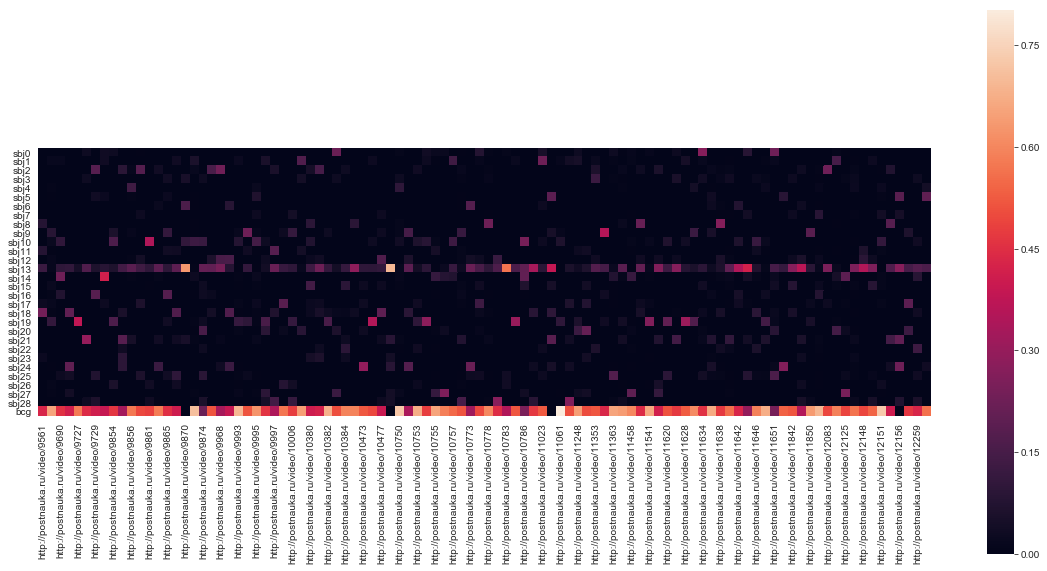

In [20]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(teta_new, square=True)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [21]:
name=theta.columns

1728

In [60]:
arr=list()
for i in range(30):
    teta_1=theta.ix[i,range(100)]
    arr.append(teta_1.mean())

C:\Users\user\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
arr

[0.012722986750304699,
 0.012788009829819202,
 0.017880607396364212,
 0.006758710369467735,
 0.004394464660435915,
 0.008814719505608082,
 0.006152039393782616,
 0.003855824237689376,
 0.011799287982285023,
 0.018451876938343048,
 0.024722419679164886,
 0.006697315722703934,
 0.01380832213908434,
 0.14560745656490326,
 0.01853637583553791,
 0.008672538213431835,
 0.007396174594759941,
 0.010950827971100807,
 0.019424080848693848,
 0.037971220910549164,
 0.012461118400096893,
 0.021320533007383347,
 0.00583554757758975,
 0.003991256467998028,
 0.021207857877016068,
 0.012656706385314465,
 0.004531097132712603,
 0.014057324267923832,
 0.016437141224741936,
 0.4900961220264435]

In [62]:
len(arr)

30

In [63]:
# Ваш код
frame = pd.DataFrame({'names':topic_names, 'p':arr})

In [64]:
frame

,names,p
0,sbj0,0.012723
1,sbj1,0.012788
2,sbj2,0.017881
3,sbj3,0.006759
4,sbj4,0.004394
5,sbj5,0.008815
6,sbj6,0.006152
7,sbj7,0.003856
8,sbj8,0.011799
9,sbj9,0.018452


In [66]:
t=frame['p']

In [73]:
arr.sort()

In [74]:
arr

[0.003855824237689376,
 0.003991256467998028,
 0.004394464660435915,
 0.004531097132712603,
 0.00583554757758975,
 0.006152039393782616,
 0.006697315722703934,
 0.006758710369467735,
 0.007396174594759941,
 0.008672538213431835,
 0.008814719505608082,
 0.010950827971100807,
 0.011799287982285023,
 0.012461118400096893,
 0.012656706385314465,
 0.012722986750304699,
 0.012788009829819202,
 0.01380832213908434,
 0.014057324267923832,
 0.016437141224741936,
 0.017880607396364212,
 0.018451876938343048,
 0.01853637583553791,
 0.019424080848693848,
 0.021207857877016068,
 0.021320533007383347,
 0.024722419679164886,
 0.037971220910549164,
 0.14560745656490326,
 0.4900961220264435]

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [88]:
topic_labels[23]

'history USSR'

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

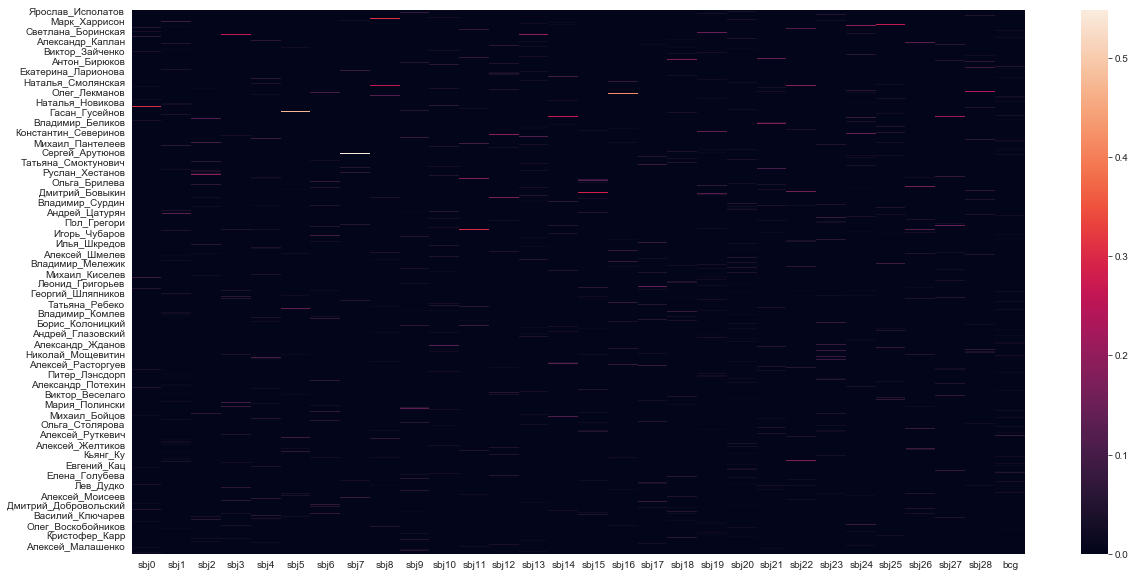

In [100]:
# Ваш код

plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a)

In [108]:
phi_a.index

Index([u'Ярослав_Исполатов', u'Сергей_Демокритов', u'Руслан_Смелянский',
       u'Александр_Апт', u'Людмила_Новикова', u'Александр_Парфенов',
       u'Джеффри_Шнапп', u'Дмитрий_Чудаков', u'Дмитрий_Дождев',
       u'Владимир_Шалаев',
       ...
       u'Дэвид_Кларк', u'Алексей_Малашенко', u'Ирина_Левонтина',
       u'Андрей_Коротаев', u'Татьяна_Гусарова', u'Дарья_Радченко',
       u'Ирина_Каспэ', u'Марина_Корсакова-Крейн', u'Павел_Степанцов',
       u'Дэвид_Гросс'],
      dtype='object', length=539)

In [121]:
arr2=list()
for j in range(539):
    count=0
    for i in range(30):
        if phi_a[j:j+1].sum()[i]>0.01:
            count+=1
    if count>=3:
        arr2.append(j)

In [122]:
arr2

[131,
 186,
 194,
 217,
 241,
 278,
 283,
 286,
 298,
 316,
 341,
 417,
 444,
 471,
 479,
 499]

In [128]:

aut=phi_a.index[131].encode('utf-8')+" "+phi_a.index[186].encode('utf-8')+" "+phi_a.index[194].encode('utf-8')+" "+phi_a.index[217].encode('utf-8')+" "+phi_a.index[241].encode('utf-8')+" "+phi_a.index[278].encode('utf-8')+" "+phi_a.index[283].encode('utf-8')+" "+phi_a.index[286].encode('utf-8')+" "+phi_a.index[298].encode('utf-8')+" "+phi_a.index[316].encode('utf-8')+" "+phi_a.index[341].encode('utf-8')+" "+phi_a.index[417].encode('utf-8')+" "+phi_a.index[444].encode('utf-8')+" "+phi_a.index[471].encode('utf-8')+" "+phi_a.index[479].encode('utf-8')+" "+phi_a.index[499].encode('utf-8')
print aut.decode('utf-8')

Александр_Филиппов Фёдор_Успенский Михаил_Алексеевский Мария_Фаликман Николай_Дронин Илья_Иткин Олег_Ауров Анатолий_Баранов Константин_Мирошников Александр_Тормасов Ян_Левченко Андрей_Чабовский Павел_Нерлер_(Полян) Ольга_Вайнштейн Андрей_Журавлев Александр_Пиперски


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [132]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.000000e+00,0.000000e+00,0.000000e+00,1.532128e-11,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Сергей_Демокритов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,3.723451e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Руслан_Смелянский,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,7.835052e-02,...,5.837262e-10,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Александр_Апт,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,2.121886e-13,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Людмила_Новикова,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.053579,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Александр_Парфенов,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,3.906372e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.045479,0.000000
Джеффри_Шнапп,0.000000e+00,0.000000e+00,0.000000e+00,5.205653e-16,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Дмитрий_Чудаков,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Дмитрий_Дождев,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,3.068786e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000
Владимир_Шалаев,0.000000e+00,3.344886e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,3.723418e-02,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000


In [ ]:
# Ваш код
mds = manifold.MDS(n_components=2)
MDS_transformed_cos = mds.fit_transform(pairwise_distances(data_subset, metric = "cosine"))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [ ]:
# Ваш код


Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [1]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 